# Analysis of Rolling Sales Data - Queens

# Steps

I am going to do the following:

    1. Import necessary modules
    2. Load the prepped data per borough 
    3. Analyze the data for trends and seasonality
    4. Dickey-Fuller Tests and preparing data for ARMA modeling by inducing stationarity
    5. ARMA model of the data
    6. Error analysis of the ARMA model
    7. Comparison with latest data
    8. Onservations/Conclusions

## 1. Imports

In [57]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn
import math

## 2. Loading the prepared data

##### Observations: 
 - Once I loaded the data and sorted it, the SALE DATE values range from 4/1/2020 until 3/31/2021.
 - This data was the most recent data when I started working on the project. 
 - NYC OpenData website updates this data regularly with newer months about every 2-3 months

In [58]:
df = pd.read_csv('rollingsales_queens.xls_prepped_bare.csv')
df.reset_index(drop=True, inplace=True)
df.sort_values('SALE DATE')

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
11776,1,11434,434500,2020-04-01
5303,2,11375,1150000,2020-04-01
10406,4,11418,2500000,2020-04-01
11814,1,11434,358000,2020-04-01
12658,1,11357,720000,2020-04-01
...,...,...,...,...
13114,2,11377,370000,2021-03-31
10094,1,11418,773800,2021-03-31
5566,2,11004,167600,2021-03-31
5156,2,11375,425000,2021-03-31


## 3. Analyzing the data for trends/seasonality

I do the following steps here to help the data work with the modules:

    1. Convert 'SALE DATE' column to datetime format
    2. Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
    3. Since we have multiple sales per day, I will aggregate the data into daily data by taking the daily average of sales
    4. Check the data for any nulls/NaNs
    5. Use statsmodels to observe the data for trends and seasonality
    
##### Observations:
    - NaN values came into the data after the data got aggregated. 
    - Upon further inspection, this was due to the 70 days of no sales in the origional data. 
    - Thus, after aggregation, there were 70 days with no data, which I dropped

In [59]:
# Convert 'SALE DATE' column to datetime format
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [60]:
# Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])
df_price_date = df_price_date.set_index('SALE DATE')
df_price_date.head()

,SALE PRICE
SALE DATE,
2020-07-16,4121000
2020-08-28,584569
2021-01-11,800000
2020-12-16,300000
2020-06-23,360000


In [61]:
#Group the sales data by daily average
df_price_date = df_price_date.resample('D').mean()

In [62]:
# We see here number of rows went down from 13171 to 295. Why wasn't it 365 rows to represent all days of the year?
df_price_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-04-01 to 2021-03-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SALE PRICE  295 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [63]:
#Here we see that since we resampled by day, there are NaN values for the days that there were no sales due to no sale date, pandas autofilled it with NaN
df_price_date['SALE PRICE'].isna().sum()

70

In [64]:
# df_price_date.dropna(inplace=True)
df_price_date['SALE PRICE'].fillna(0, inplace=True)
df_price_date

,SALE PRICE
SALE DATE,
2020-04-01,961150.000000
2020-04-02,753357.142857
2020-04-03,681724.206897
2020-04-04,0.000000
2020-04-05,0.000000
...,...
2021-03-27,0.000000
2021-03-28,0.000000
2021-03-29,694114.470588


In [65]:
# df_price_date.rolling(window=2).mean().head()
df_price_date['roll_avg'] = df_price_date.rolling(window=7).mean()
df_price_date

,SALE PRICE,roll_avg
SALE DATE,,
2020-04-01,961150.000000,NaN
2020-04-02,753357.142857,NaN
2020-04-03,681724.206897,NaN
2020-04-04,0.000000,NaN
2020-04-05,0.000000,NaN
...,...,...
2021-03-27,0.000000,460444.131063
2021-03-28,0.000000,456158.416777
2021-03-29,694114.470588,463897.318187


I plotted the data here against its 7 day rolling average to see if I can discern any pattern

Text(0, 0.5, 'Average Price')

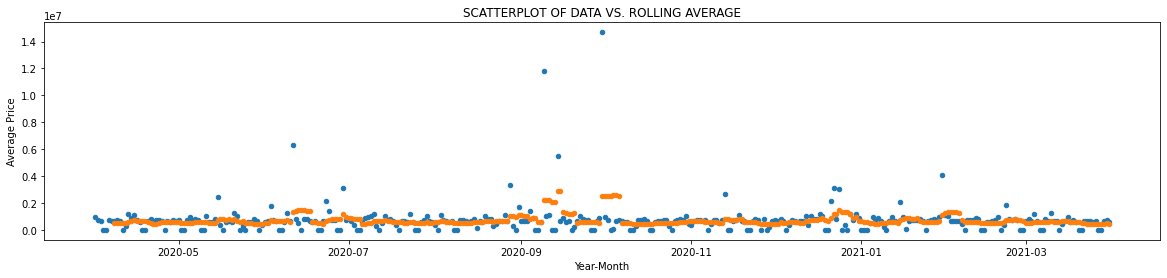

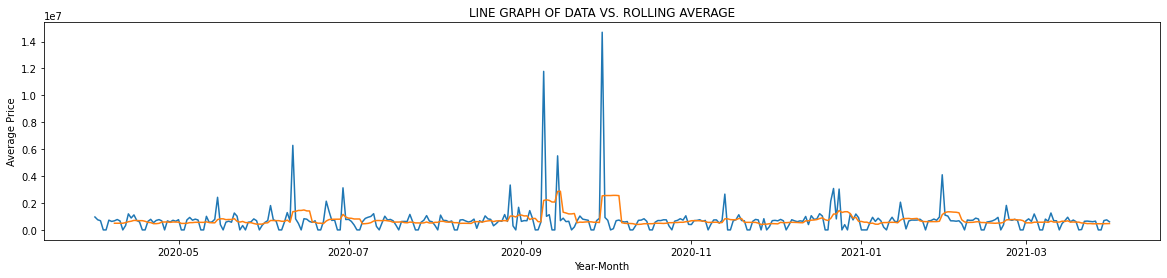

In [66]:
plt.figure(figsize=(20, 4))
plt.title("SCATTERPLOT OF DATA VS. ROLLING AVERAGE")
plt.xlabel("Year-Month")
plt.ylabel("Average Price")
#s=20 to keep dots small in size
plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
plt.scatter(df_price_date.index[7:], df_price_date['roll_avg'][7:], s=20);
plt.figure(figsize=(20, 4))
plt.title("LINE GRAPH OF DATA VS. ROLLING AVERAGE")
plt.plot(df_price_date.index[:365], df_price_date['SALE PRICE'][:365])
plt.plot(df_price_date.index[7:], df_price_date['roll_avg'][7:]);
plt.xlabel("Year-Month")
plt.ylabel("Average Price")

In [67]:
# Statsmodels
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=7)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [68]:
register_matplotlib_converters()

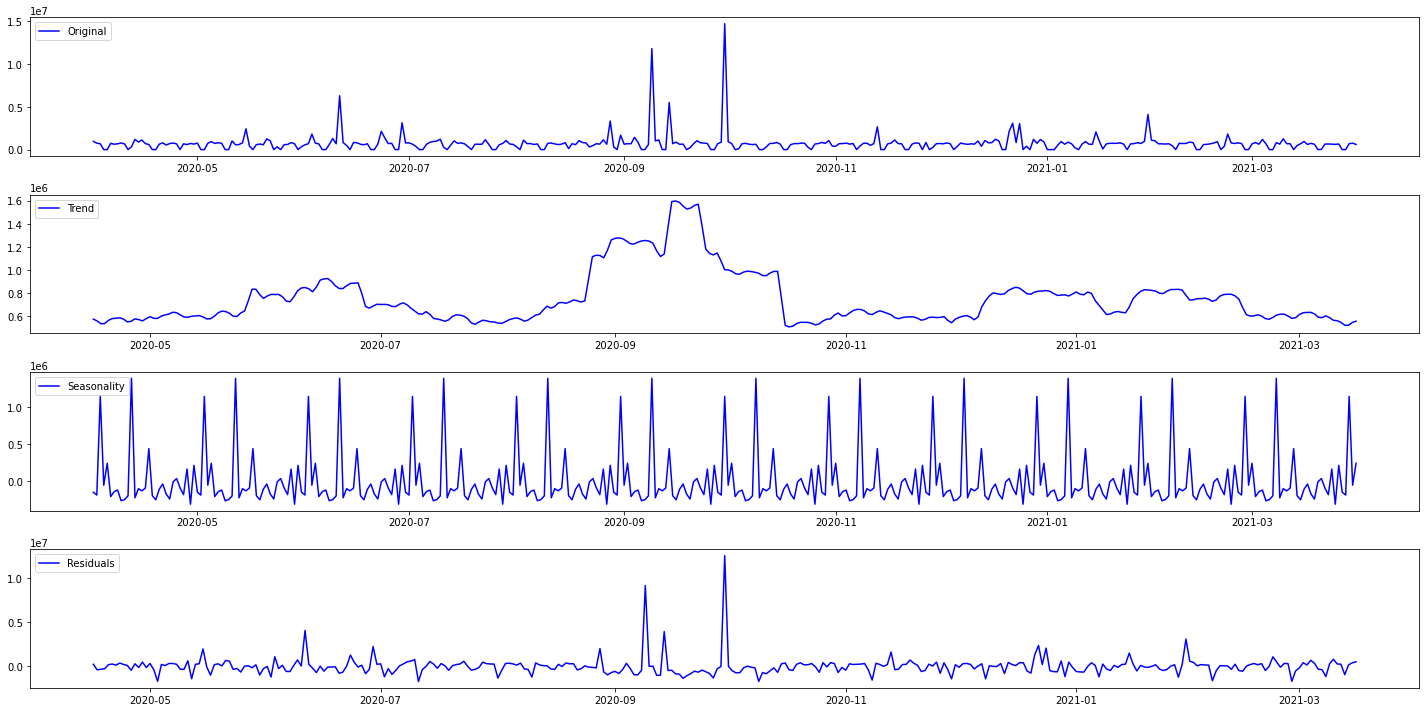

In [69]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

##### Observations: 
 - A large amount of sales happened between August 2020 and November 2020. 
 - There was some seasonality that happened once a month and in the middle of the month

## 4. Dickey-Fuller Tests and preparing data for ARMA modeling by inducing stationarity

I had to do the following to induce stationarity:

In [70]:
# Initial test
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-8.565541911900292, 8.466399684197556e-14, 4, 360, {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}, 10680.436655510479)

Test Statistic                -8.565542e+00
p-value                        8.466400e-14
#Lags Used                     4.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


### Augmented Dickey Fuller Test Goals: 

Our goal is to induce stationarity and show that the data does not have a unit root. 

ADF Test Null Hypothesis: The data has a unit root and is non-stationary.

Requirements for stationarity:

    1. If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
        - If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    2. If the Test Statistic is lower than the critical values, then reject the null hypothesis. Data does not have a unity root and is stationary


### Results of ADF Test

<b><u>Test Statistic vs. Critical Values</b></u>
- Initial test shows Test Statistic of **-2.6448**, this is greater than the critical values for 1% and 5%.
    - <i>We fail to reject the null hypothesis that the time series is not stationary!</i>

<b><u>P-Value Analysis</b></u>


- Our current p-value is **0.084092**
    - <i>This means: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.</i>

In [71]:
#Logging the data and then rerunning ADF test

# df_price_date['SALE_PRICE_LOGGED'] = df_price_date['SALE PRICE'].apply(lambda x : np.log(x))

In [72]:
# df_price_date['SALE_PRICE_LOGGED']

In [73]:
# plt.figure(figsize=(20, 4))
# # plt.title("SCATTERPLOT OF DATA VS. ROLLING AVERAGE")
# plt.xlabel("Year-Month")
# plt.ylabel("Average Price")
# #s=20 to keep dots small in size
# df_price_date['SALE_PRICE_LOGGED'].plot(color="tab:green", title="LOG TRANSFORMED VALUES");

# plt.figure(figsize=(20, 4))
# plt.title("LINE GRAPH OF DATA VS. ROLLING AVERAGE")
# df_price_date['SALE PRICE'].plot(color="tab:blue", title="ORIGINAL VALUES");
# plt.xlabel("Year-Month")
# plt.ylabel("Average Price")

In [74]:
# # Initial test
# dftest = adfuller(df_price_date['SALE_PRICE_LOGGED'])
# dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# for key,value in dftest[4].items():
#     dfoutput['Critical Value (%s)'%key] = value
# print(dftest)
# print()
# print(dfoutput)

### Results of ADF Test

<b><u>Test Statistic vs. Critical Values</b></u>
- Initial test shows Test Statistic of **-5.053760**, this is greater than the critical values for 1% and 5%.
    - <i>We **REJECT** the null hypothesis! The data does not have a unit root and is stationary</i>

<b><u>P-Value Analysis</b></u>


- Our current p-value is **0.000017**
    - <i>This means: p-value <= 0.05: </i>
    - <i>We **REJECT** the null hypothesis! The data does not have a unit root and is stationary</i>

## 5. ARMA MODELING

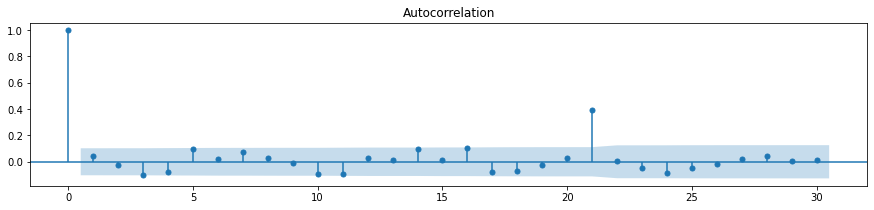

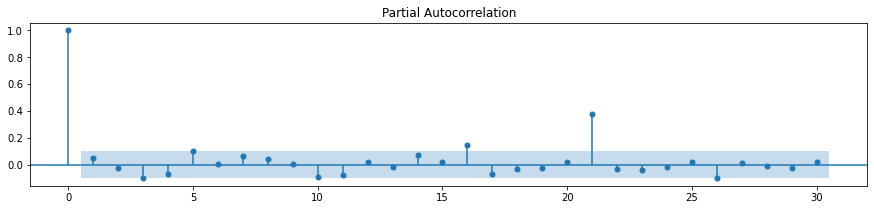

In [75]:
# ACF AND PACF

rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date['SALE PRICE'], lags=30, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date['SALE PRICE'], lags=30, alpha=0.05);

In [77]:
df_price_date['SALE PRICE']

SALE DATE
2020-04-01    961150.000000
2020-04-02    753357.142857
2020-04-03    681724.206897
2020-04-04         0.000000
2020-04-05         0.000000
                  ...      
2021-03-27         0.000000
2021-03-28         0.000000
2021-03-29    694114.470588
2021-03-30    747610.935484
2021-03-31    602154.750000
Freq: D, Name: SALE PRICE, Length: 365, dtype: float64

In [78]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 5

# q = lagged forecast errors - PACF
q = 5

#d = number of differences



# Fitting ARMA model and summary
ar = ARMA(df_price_date['SALE PRICE'],(p,q)).fit()
ar.summary()

C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  365
Model:                     ARMA(5, 5)   Log Likelihood               -5588.405
Method:                       css-mle   S.D. of innovations        1062824.560
Date:                Sun, 20 Jun 2021   AIC                          11200.810
Time:                        12:16:25   BIC                          11247.609
Sample:                    04-01-2020   HQIC                         11219.408
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              7.33e+05   5.79e+04     12.654      0.000     6.2e+05    8.47e+05
ar.L1.SALE PRICE    -0.9124        nan        nan        nan         nan         nan
ar.L2.SALE PRICE    -0.3866        nan        nan        nan         nan         nan
ar.L3.SALE PRICE    -0.4637        nan        nan        nan         nan         nan
ar.L4.SALE PRICE    -0.9571        nan        nan        nan         nan         nan
ar.L5.SALE PRICE    -0.9011        nan        nan        nan         nan         nan
ma.L1.SALE PRICE     0.9621      0.022     44.568      0.000       0.920       1.004
ma.L2.SALE PRICE     0.4438      0.029     15.290      0.000       0.387       0.501
ma.L3.SALE PRICE     0.4430      0.031     14.354      0.000       0.382       0.503
ma.L4.SALE PRICE     0.9637      0.038     25.625      0.000       0.890       1.037
ma.L5.SALE PRICE     0.9984      0.030     33.307      0.000       0.940       1.057
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6239           -0.7816j            1.0001           -0.1428
AR.2            0.6239           +0.7816j            1.0001            0.1428
AR.3           -0.6407           -0.8175j            1.0387           -0.3558
AR.4           -0.6407           +0.8175j            1.0387            0.3558
AR.5           -1.0285           -0.0000j            1.0285           -0.5000
MA.1            0.6256           -0.7802j            1.0000           -0.1424
MA.2            0.6256           +0.7802j            1.0000            0.1424
MA.3           -0.6074           -0.7944j            1.0000           -0.3539
MA.4           -0.6074           +0.7944j            1.0000            0.3539
MA.5           -1.0016           -0.0000j            1.0016           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# start_index = len(df_price_date['SALE_PRICE_LOGGED'])
# end_index = start_index + 30
# forecast = ar.predict(start=start_index, end=end_index)
# start_index
# end_index

In [ ]:
# dta.index = pd.date_range(start='1700', end='2009', freq='A')

# df_price_date.index= pd.to_datetime(df_price_date.index, format="%Y/%m/%d")

In [ ]:
df_price_date.reset_index(inplace=True)

In [ ]:
df_price_date.index

In [ ]:
df_price_date

In [ ]:
#plot of ARMA model
fig, ax = plt.subplots()
# ax = df_price_date['SALE_PRICE_LOGGED'].plot(ax=ax, title='FORECAST')
ax = df_price_date['SALE PRICE'].plot(ax=ax, title='FORECAST')
fig = ar.plot_predict(365, 395, dynamic=True, ax=ax, plot_insample=True)
plt.show()

In [ ]:
excel_df = pd.read_csv('NYC_Citywide_Rolling_Calendar_Sales.csv', usecols=['BOROUGH', 'SALE DATE', 'SALE PRICE'])
excel_df = excel_df[excel_df['BOROUGH']=='QUEENS']
# excel_df['SALE PRICE'].astype(int)

In [ ]:
# excel_df['SALE PRICE'].astype(int)

# excel_df['SALE_PRICE_LOGGED'] = excel_df['SALE PRICE'].apply(lambda x : np.log(x))
excel_df.reset_index(drop=True, inplace=True)
# excel_df

In [ ]:
excel_df['SALE PRICE'] = excel_df['SALE PRICE'].str.replace(',','')

In [ ]:
excel_df['SALE PRICE'] = excel_df['SALE PRICE'].astype(int)

In [ ]:
excel_df['SALE DATE'] = pd.to_datetime(excel_df['SALE DATE'])

In [ ]:
excel_price_date = pd.DataFrame(excel_df, columns=['SALE DATE', 'SALE PRICE'])
excel_price_date = excel_price_date.set_index('SALE DATE')
# excel_price_date.dropna(inplace=True)

In [ ]:
excel_price_date = excel_price_date.resample('D').mean()

In [ ]:
excel_price_date = excel_price_date.fillna(0)
# excel_price_date

In [ ]:
excel_price_date.head()

In [ ]:
# excel_price_date.isnull().sum()
#  df = df[(df.T != 0).any()]
# excel_price_date = excel_price_date[(excel_price_date['SALE PRICE'] !=0)]

In [ ]:
excel_price_date

In [ ]:
# excel_price_date['SALE_PRICE_LOGGED'] = excel_price_date['SALE PRICE'].apply(lambda x : np.log(x))

In [ ]:
excel_price_date

In [ ]:
# #plot of ARMA model
# plt.figure(figsize=(20,10))
# # figsize(20,10)

# x1= df_price_date.index
# y1=df_price_date['SALE PRICE']
# plt.plot(x1,y1)
# # x2= np.array(range(365,396))
# # y2= np.array(ar.predict(366,395))
# fig = ar.plot_predict(365, 395, dynamic=True, ax=ax, plot_insample=True)
# plt.plot(x2,y2)
# x3= range(365,395)
# y3=excel_price_date['SALE PRICE'][335:366]
# plt.plot(x3,y3)

In [ ]:
fig, ax = plt.subplots()
# ax = df_price_date['SALE_PRICE_LOGGED'].plot(ax=ax, title='FORECAST')
ax = excel_price_date['SALE PRICE'].plot(title='RECENT DATA vs. FORECAST', color='green')
# ax1 = excel_price_date['SALE PRICE'].plot(ax=ax1)
fig = ar.plot_predict(365, 395, dynamic=True, ax = ax, plot_insample=True)
handles, labels = ax.get_legend_handles_labels()
labels = ['RECENT APRIL 2021 DATA SALE PRICE', 'FORECAST','95% confidence interval']
ax.legend(handles, labels)
plt.show()

In [ ]:
#r^2 score
r2_score(df_price_date['SALE PRICE'], ar.predict())
# Low r^2 indicates a good fit

In [ ]:
#Predicting ERROR
predictions = list(ar.predict(365, 394))
test = list(excel_price_date['SALE PRICE'][335:365])

In [ ]:
print(len(predictions))
print(len(test))
print(test)

In [ ]:
mse = sklearn.metrics.mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
rmse

#RMSE very high due to huge sale

In [ ]:
plt.plot(predictions, color='blue')
plt.plot(test, color='green')
x=[0,30]
y=[rmse,rmse]
plt.plot(x,y, color='red')

In [ ]:
#Predicting ERROR when we remove the last 4 days to get rid of the huge sale, we see there is a RMSE within the range of the data
predictions = list(ar.predict(365, 393))
test = list(excel_price_date['SALE PRICE'][335:364])
print(len(predictions))
print(len(test))
mse = sklearn.metrics.mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
rmse
plt.plot(predictions, color='blue')
plt.plot(test, color='green')

x=[0,29]
y=[rmse,rmse]
plt.plot(x,y, color='red')

In [ ]:
print(rmse)
print(mse)
#this rmse looks acceptable. It is not too low nor high with outlier removed
